In [1]:
# Import all modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssm # This package is a little niche - refer to the readme instructions about obtaining it

In [2]:
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions (probability of choice)
num_categories = 2    # number of categories for output (L vs R)
input_dim = 3         # input dimensions (covariates)

In [3]:
# Load human data
human_data = pd.read_csv("combined_blocks_humans_GLM.csv")
human_data.head()

,subj_idx,stim,rt,response,accuracy,stimulus_displayed,response_mode,previousResponse
0,2,-0.166667,0.4346,0,1,cylinder,buttons,0
1,2,-1.000000,0.4512,0,1,cylinder,buttons,0
2,2,1.000000,0.3177,1,1,cylinder,buttons,0
3,2,0.083333,0.3343,0,0,cylinder,buttons,1
4,2,0.083333,0.3342,0,0,cylinder,buttons,0


In [4]:
# Pre-processing 

# Due to initial incorrect coding (a participant pressing the wrong button), there may be some incorrectly coded
# trials with a response of -1, though they should all be 0 or one. Make sure to drop these
human_data.drop(human_data.index[human_data['response'] == -1], inplace=True)

# Rename one column
human_data.rename(columns={"previousResponse":"previous_response"}, inplace=True)

# Ensure we get the previous response right
human_data.previous_response *= 2
human_data.previous_response += -1 

# This is for the bias 
human_data['num_of_resps'] = 1

# Sort into cylinder and RDK
human_data_C = human_data[human_data.stimulus_displayed == "cylinder"].reset_index(drop=True)
human_data_D = human_data[human_data.stimulus_displayed != "cylinder"].reset_index(drop=True)

# Sort into buttons and saccades
human_data_B = human_data[human_data.response_mode == "buttons"].reset_index(drop=True)
human_data_S = human_data[human_data.response_mode != "buttons"].reset_index(drop=True)

In [5]:
# Change the normalisation of the data to make it relative to threshold (NB: hardcoded values from earlier)

human_data_C.loc[human_data_C.response_mode == "saccades", "stim"] *= 0.08 / 0.01
human_data_C.loc[human_data_C.response_mode == "buttons", "stim"] *= 0.08 / 0.011

human_data_D.loc[human_data_D.response_mode == "saccades", "stim"] *= 50 / 13.6
human_data_D.loc[human_data_D.response_mode == "buttons", "stim"] *= 50 / 11.8

human_data_B.loc[human_data_B.stimulus_displayed == "cylinder", "stim"] *= 0.08 / 0.011
human_data_B.loc[human_data_B.stimulus_displayed == "dots", "stim"] *= 50 / 11.8

human_data_S.loc[human_data_S.stimulus_displayed == "cylinder", "stim"] *= 0.08 / 0.01
human_data_S.loc[human_data_S.stimulus_displayed == "dots", "stim"] *= 50 / 13.6

In [12]:
# Prepare the data for the GLM-HMM (stimuli)

stim_C = np.empty((20, 1029, 3))
stim_D = np.empty((20, 1029, 3))
choices_C = np.empty((20, 1029, 1))
choices_D = np.empty((20, 1029, 1))

list_trials_btts_C = []
list_trials_btts_D = []

for count, session in enumerate(human_data.subj_idx.unique()):

    stim_C[count, :, :] = human_data_C.loc[human_data_C.subj_idx == session, ["stim", "previous_response", "num_of_resps"]][0:1029]
    stim_D[count, :, :] = human_data_D.loc[human_data_D.subj_idx == session, ["stim", "previous_response", "num_of_resps"]][0:1029]

    human_data_C.loc[human_data_C.subj_idx == session, "response_mode"].unique()[0]
    human_data_D.loc[human_data_D.subj_idx == session, "response_mode"].unique()[0]
    
    list_trials_btts_C.append((human_data_C.loc[human_data_C.subj_idx == session, "response_mode"] == "buttons").sum())
    list_trials_btts_D.append((human_data_D.loc[human_data_D.subj_idx == session, "response_mode"] == "buttons").sum())
    
    choices_C[count, :] = np.array(human_data_C.loc[human_data_C.subj_idx == session, ["response"]][0:1029])
    choices_D[count, :] = np.array(human_data_D.loc[human_data_D.subj_idx == session, ["response"]][0:1029])

# Make sure the choices are integers
choices_C = choices_C.astype(int)
choices_D = choices_D.astype(int)

choices_C = list(choices_C)
stim_C = list(stim_C)
choices_D = list(choices_D)
stim_D = list(stim_D)

In [13]:
human_data_C.loc[human_data_C.subj_idx == session, ["stim", "previous_response", "num_of_resps"]][0:1029]

,stim,previous_response,num_of_resps
28563,7.272727,-1,1
28564,3.636364,1,1
28565,1.212121,1,1
28566,1.212121,1,1
28567,-3.636364,1,1
...,...,...,...
29587,-8.000000,-1,1
29588,-4.000000,-1,1
29589,-1.333333,-1,1
29590,-4.000000,-1,1


In [33]:
# Prepare the data for the GLM-HMM (modes of response)

stim_B = np.empty((20, 1029, 3))
stim_S = np.empty((20, 1029, 3))
choices_B = np.empty((20, 1029, 1))
choices_S = np.empty((20, 1029, 1))

list_trials_btts_B = []
list_trials_btts_S = []

for count, session in enumerate(human_data.subj_idx.unique()):

    stim_B[count, :, :] = human_data_B.loc[human_data_B.subj_idx == session, ["stim", "previous_response", "num_of_resps"]][0:1029]
    stim_S[count, :, :] = human_data_S.loc[human_data_S.subj_idx == session, ["stim", "previous_response", "num_of_resps"]][0:1029]

    human_data_B.loc[human_data_B.subj_idx == session, "stim"].unique()[0]
    human_data_S.loc[human_data_S.subj_idx == session, "stim"].unique()[0]
    
    choices_B[count, :] = np.array(human_data_B.loc[human_data_B.subj_idx == session, ["response"]][0:1029])
    choices_S[count, :] = np.array(human_data_S.loc[human_data_S.subj_idx == session, ["response"]][0:1029])

# Make sure the choices are integers
choices_B = choices_B.astype(int)
choices_S = choices_S.astype(int)

choices_B = list(choices_B)
stim_B = list(stim_B)
choices_S = list(choices_S)
stim_S = list(stim_S)

In [11]:
# Set up a 5-fold cross-validation for RDK 
inpts_list_D = [stim_D[4:], stim_D[0:4] + stim_D[8:], stim_D[0:8] + stim_D[12:], 
              stim_D[0:12] + stim_D[16:], stim_D[0:16]]

test_list_stim_D = [stim_D[0:4], stim_D[4:8], stim_D[8:12], stim_D[12:16], stim_D[16:20]]


datas_list_D = [choices_D[4:], choices_D[0:4] + choices_D[8:], choices_D[0:8] + choices_D[12:], 
              choices_D[0:12] + choices_D[16:], choices_D[0:16]]

test_list_choices_D = [choices_D[0:4], choices_D[4:8], choices_D[8:12], choices_D[12:16], choices_D[16:20]]

In [12]:
# Set up a 5-fold cross-validation for Cylinder
inpts_list_C = [stim_C[4:], stim_C[0:4] + stim_C[8:], stim_C[0:8] + stim_C[12:], 
              stim_C[0:12] + stim_C[16:], stim_C[0:16]]

test_list_stim_C = [stim_C[0:4], stim_C[4:8], stim_C[8:12], stim_C[12:16], stim_C[16:20]]


datas_list_C = [choices_C[4:], choices_C[0:4] + choices_C[8:], choices_C[0:8] + choices_C[12:], 
              choices_C[0:12] + choices_C[16:], choices_C[0:16]]

test_list_choices_C = [choices_C[0:4], choices_C[4:8], choices_C[8:12], choices_C[12:16], choices_C[16:20]]

In [11]:
# Cylinder
total_params_C = np.empty((5, 3, 1, 3))
total_test_LL_C = np.empty((5, 5))
init_array = np.empty(((3, 1, 3)))

# Create a new array with [0, 0, 0]
zeros_array = np.array([[[0, 0, 0]]])

for model_type in range(5):
    for fold in range(5):
        inpts = inpts_list_C[fold]
        datas = datas_list_C[fold]

        glmhmm_C_LL = ssm.HMM(model_type+1, obs_dim, input_dim, observations="input_driven_obs", 
                       observation_kwargs=dict(C=num_categories), transitions="standard")
        
        # Make sure we initialise from the previous iteration 
        if model_type == 0:
            pass
        else:
            glmhmm_C_LL.observations.params = init_array
            glmhmm_C_LL.observations.params = np.vstack((glmhmm_C_LL.observations.params, zeros_array))

        glmhmm_C_LL.fit(datas, inputs=inpts, method="em", num_iters=200, tolerance=10**-4)

        total_test_LL_C[fold, model_type] = glmhmm_C_LL.log_likelihood(test_list_choices_C[fold], inputs=test_list_stim_C[fold])


    init_array = glmhmm_C_LL.observations.params


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
# RDK
total_params_D = np.empty((5, 3, 1, 3))
total_test_LL_D = np.empty((5, 5))

for model_type in range(5):
    for fold in range(5):
        inpts = inpts_list_D[fold]
        datas = datas_list_D[fold]

        glmhmm_D_LL = ssm.HMM(model_type+1, obs_dim, input_dim, observations="input_driven_obs", 
                       observation_kwargs=dict(C=num_categories), transitions="standard")
        
        # Make sure we initialise from the previous iteration 
        if model_type == 0:
            pass
        else:
            glmhmm_D_LL.observations.params = init_array
            glmhmm_D_LL.observations.params = np.vstack((glmhmm_D_LL.observations.params, zeros_array))

        glmhmm_D_LL.fit(datas, inputs=inpts, method="em", num_iters=200, tolerance=10**-4)

        total_test_LL_D[fold, model_type] = glmhmm_D_LL.log_likelihood(test_list_choices_D[fold], inputs=test_list_stim_D[fold])
        
    init_array = glmhmm_D_LL.observations.params        

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

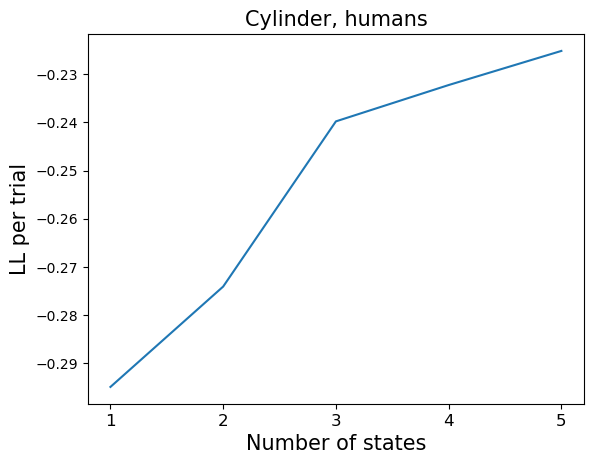

In [13]:
# Plot the LL per trial
LL_per_trial_C = total_test_LL_C.mean(axis=0)/(1029*4)
plt.plot(range(1, 6), LL_per_trial_C)
plt.xticks([1, 2, 3, 4, 5], fontsize=12)
plt.ylabel("LL per trial", fontsize=15)
plt.xlabel("Number of states", fontsize=15)
plt.title("Cylinder, humans", fontsize=15)
plt.savefig("cyl_GLM_LL.svg", bbox_inches='tight')

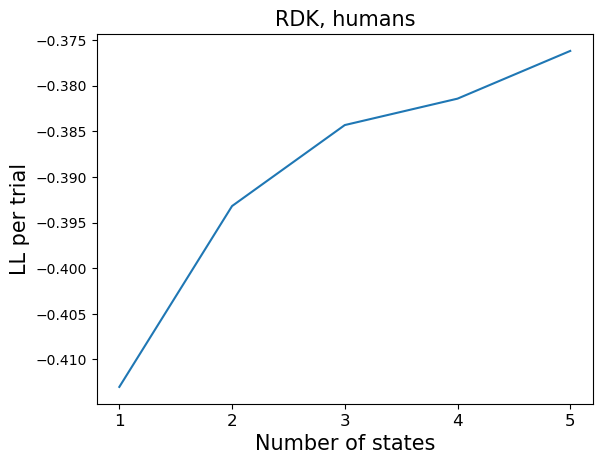

In [14]:
# Plot the LL per trial
LL_per_trial_D = total_test_LL_D.mean(axis=0)/(1029*4)
plt.plot(range(1, 6), LL_per_trial_D)
plt.xticks([1, 2, 3, 4, 5], fontsize=12)
plt.ylabel("LL per trial", fontsize=15)
plt.xlabel("Number of states", fontsize=15)
plt.title("RDK, humans", fontsize=15)
plt.savefig("RDK_GLM_LL.svg", bbox_inches='tight')

In [38]:
# Fit the models using the entire dataset - 3 states 
glmhmm_C_3 = ssm.HMM(3, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

glmhmm_D_3 = ssm.HMM(3, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below

fit_llC3 = glmhmm_C_3.fit(choices_C, inputs=stim_C, method="em", num_iters=N_iters, tolerance=10**-4)
fit_llD3 = glmhmm_D_3.fit(choices_D, inputs=stim_D, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

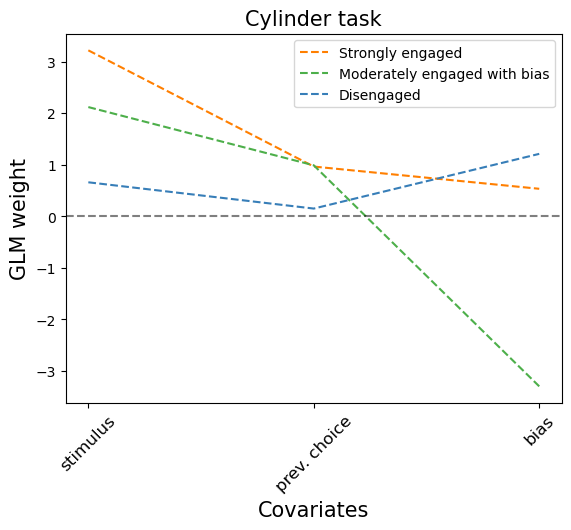

In [29]:
# Plot the cylinder 
cols = ['#ff7f00', '#4daf4a', '#377eb8']

for count, k in enumerate([0, 2, 1]):
    
    plt.plot(range(input_dim), -glmhmm_C_3.observations.params[k][0], color=cols[count],
                 lw=1.5,  linestyle = '--')

plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariates", fontsize=15)
plt.xticks([0, 1, 2], ['stimulus', "prev. choice", 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend(["Strongly engaged", "Moderately engaged with bias",  "Disengaged"])
plt.title("Cylinder task", fontsize=15)
plt.savefig("cyl_GLM.svg", bbox_inches='tight')

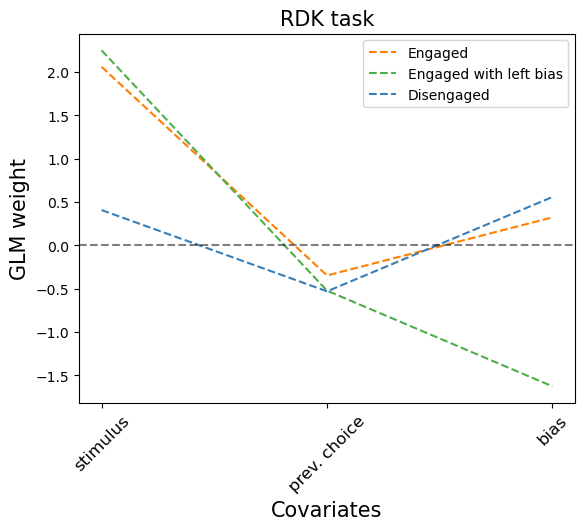

In [31]:
# Plot the RDK
cols = ['#ff7f00', '#4daf4a', '#377eb8']

for count, k in enumerate([0, 2, 1]):
    plt.plot(range(input_dim), -glmhmm_D_3.observations.params[k][0], color=cols[count],
                     lw=1.5,  linestyle = '--')
        
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariates", fontsize=15)
plt.xticks([0, 1, 2], ['stimulus', "prev. choice", 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend(["Engaged", "Engaged with left bias", "Disengaged"])
plt.title("RDK task", fontsize=15)
plt.savefig("RDK_GLM.svg", bbox_inches='tight')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Hand responses only')

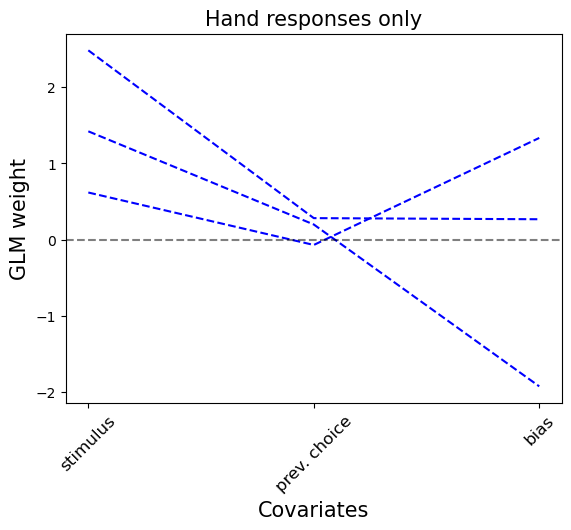

In [34]:
# Fit the models using the entire dataset - grouped for the hand motor response 
glmhmm_B_3 = ssm.HMM(3, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

glmhmm_S_3 = ssm.HMM(3, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below

fit_llB3 = glmhmm_B_3.fit(choices_B, inputs=stim_B, method="em", num_iters=N_iters, tolerance=10**-4)
fit_llS3 = glmhmm_S_3.fit(choices_S, inputs=stim_S, method="em", num_iters=N_iters, tolerance=10**-4)

# Plot the hand-response model (B stands for buttons)
for count, k in enumerate([0, 2, 1]):
    
    plt.plot(range(input_dim), -glmhmm_B_3.observations.params[k][0], color="blue",
                 lw=1.5,  linestyle = '--')

plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariates", fontsize=15)
plt.xticks([0, 1, 2], ['stimulus', "prev. choice", 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("Hand responses only", fontsize=15)

Text(0.5, 1.0, 'Eye responses only')

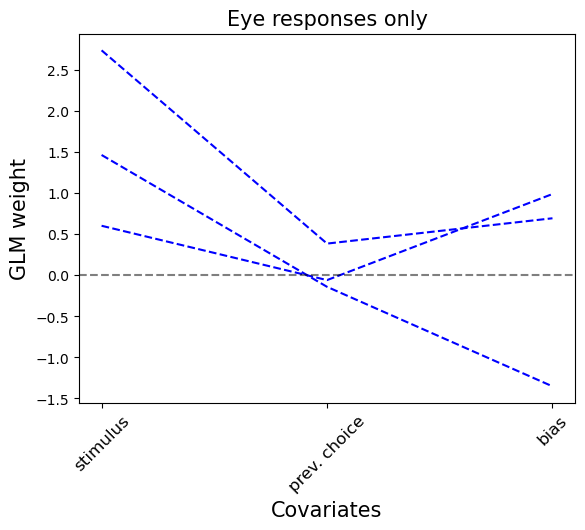

In [35]:
# Plot the eye-response model

for count, k in enumerate([0, 2, 1]):
    plt.plot(range(input_dim), -glmhmm_S_3.observations.params[k][0], color="blue",
                     lw=1.5,  linestyle = '--')
        
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariates", fontsize=15)
plt.xticks([0, 1, 2], ['stimulus', "prev. choice", 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("Eye responses only", fontsize=15)

In [39]:
# Get the posterior probs for 3 states:
posterior_probs_cyl = [glmhmm_C_3.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices_C, stim_C)]


posterior_probs_RDK = [glmhmm_D_3.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices_D, stim_D)]

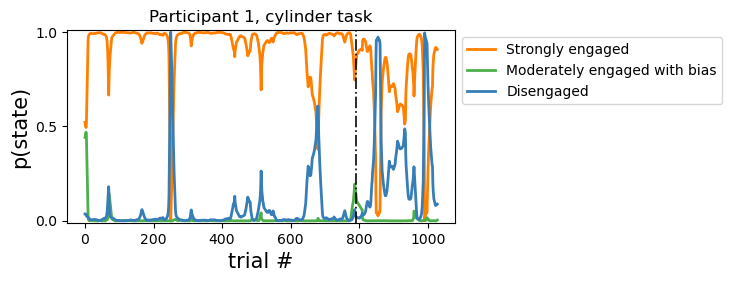

In [28]:
fig = plt.figure(figsize=(5, 2.5), facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

for count, k in enumerate([0, 2, 1]):
    plt.plot(posterior_probs_cyl[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[count])

plt.axvline(x=list_trials_btts_C[0], color='black', linestyle='-.', alpha=0.9, linewidth=1.3)
    
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(["Strongly engaged", "Moderately engaged with bias",  "Disengaged"], bbox_to_anchor=(1, 1))
plt.title("Participant 1, cylinder task")
plt.savefig("participant1_cyl_GLM.svg", bbox_inches='tight')

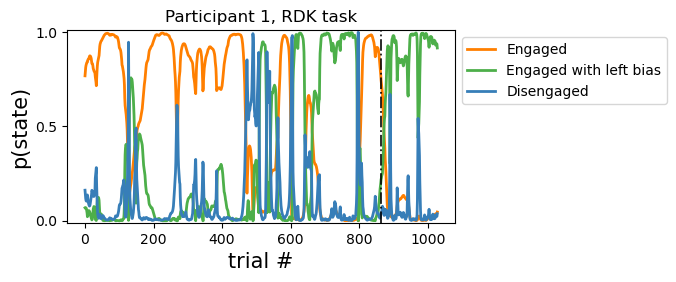

In [32]:
fig = plt.figure(figsize=(5, 2.5), facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for count, k in enumerate([0, 2, 1]):
    plt.plot(posterior_probs_RDK[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[count])

plt.axvline(x=list_trials_btts_D[0], color='black', linestyle='-.', alpha=0.9, linewidth=1.3)

plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(["Engaged", "Engaged with left bias", "Disengaged"], bbox_to_anchor=(1, 1))
plt.title("Participant 1, RDK task")
plt.savefig("participant1_RDK_GLM.svg", bbox_inches='tight')

In [40]:
# concatenate posterior probabilities across sessions
posterior_probs_concat_cyl = np.concatenate(posterior_probs_cyl)
# get state with maximum posterior probability at particular trial:
state_max_posterior_cyl = np.argmax(posterior_probs_concat_cyl, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies_cyl = np.unique(state_max_posterior_cyl, return_counts=True)
state_occupancies_cyl = state_occupancies_cyl/np.sum(state_occupancies_cyl)

# concatenate posterior probabilities across sessions
posterior_probs_concat_RDK = np.concatenate(posterior_probs_RDK)
# get state with maximum posterior probability at particular trial:
state_max_posterior_RDK = np.argmax(posterior_probs_concat_RDK, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies_RDK = np.unique(state_max_posterior_RDK, return_counts=True)
state_occupancies_RDK = state_occupancies_RDK/np.sum(state_occupancies_RDK)

In [52]:
state_occupancies_cyl2 = [state_occupancies_cyl[0], state_occupancies_cyl[2], state_occupancies_cyl[1]]
state_occupancies_RDK2 = [state_occupancies_RDK[1], state_occupancies_RDK[0], state_occupancies_RDK[2]] 

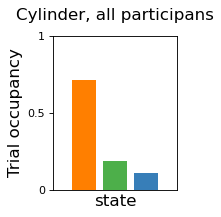

In [50]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for z, occ in enumerate(state_occupancies_cyl2):
    
    plt.bar(z, occ, width = 0.8, color = cols[z])
    
plt.ylim((0, 1))
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
# plt.legend(["Strongly engaged", "Moderately engaged with bias",  "Disengaged"], bbox_to_anchor=(1, 1))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('state', fontsize = 15)
plt.ylabel('Trial occupancy', fontsize=15)
plt.title("Cylinder, all participans", y=1.06, fontsize=15)
plt.xlim(-1, 3)
plt.savefig("Trial_occ_cyl.svg", bbox_inches='tight')

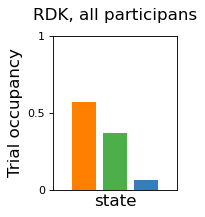

In [53]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')

for z, occ in enumerate(state_occupancies_RDK2):
    
    plt.bar(z, occ, width = 0.8, color = cols[z])
    
plt.ylim((0, 1))
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
# plt.legend(["Engaged", "Engaged with left bias", "Disengaged"], bbox_to_anchor=(2.4, 1))
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('state', fontsize = 15)
plt.ylabel('Trial occupancy', fontsize=15)
plt.title("RDK, all participans", y=1.06, fontsize=15)
plt.xlim(-1, 3)
plt.savefig("Trial_occ_RDK.svg", bbox_inches='tight')

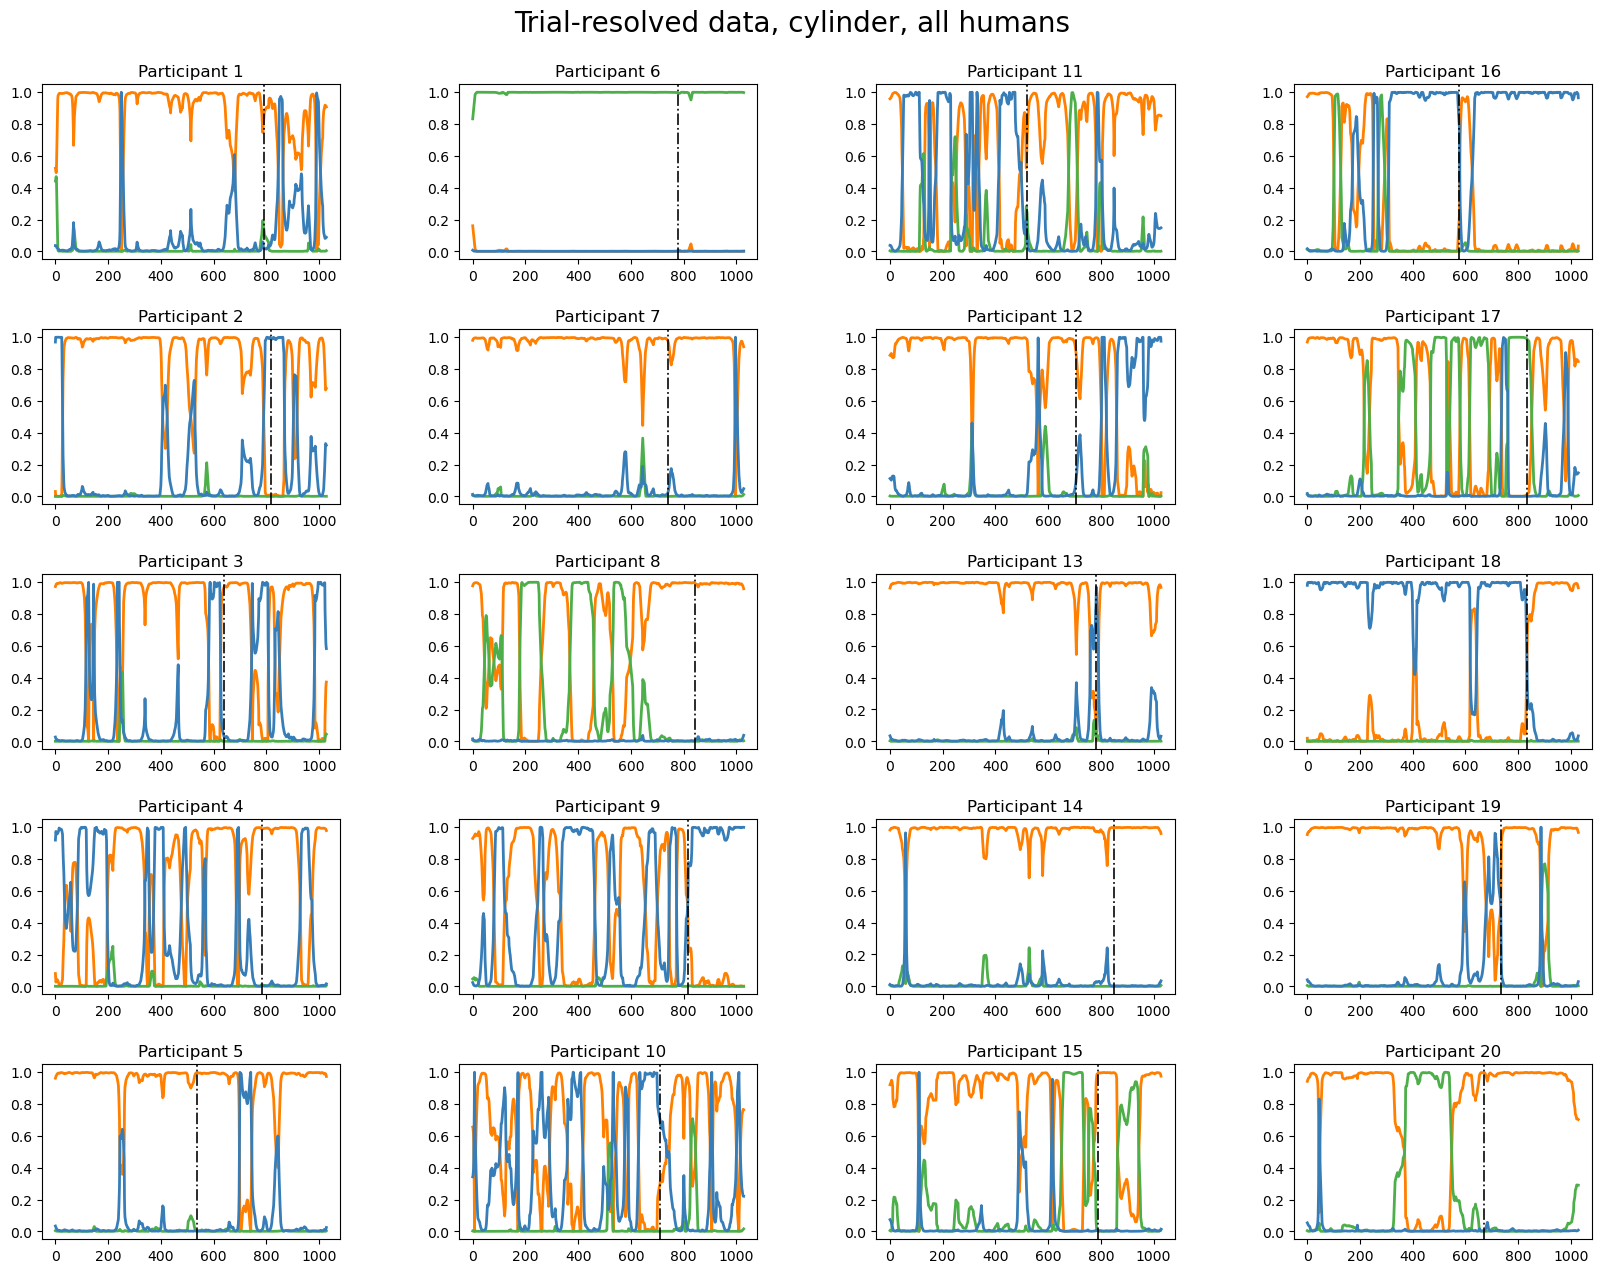

In [34]:
# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ijk = 0
klm = 0
part_id = 1

for participant in posterior_probs_cyl:
    for count, k in enumerate([0, 2, 1]):
        axes[ijk, klm].plot(participant[:, k], label="State " + str(k + 1), lw=2,
             color=cols[count])
    axes[ijk, klm].set_title(f"Participant {part_id}")
    axes[ijk, klm].axvline(x=list_trials_btts_C[part_id-1], color='black', linestyle='-.', alpha=0.9, linewidth=1.3)
    part_id += 1
    ijk += 1
    
    if ijk == 5:
        ijk = 0
        klm += 1
        
fig.suptitle('Trial-resolved data, cylinder, all humans', fontsize=20, y=0.93)
fig.savefig("cyl_all_humans_GLM.svg")

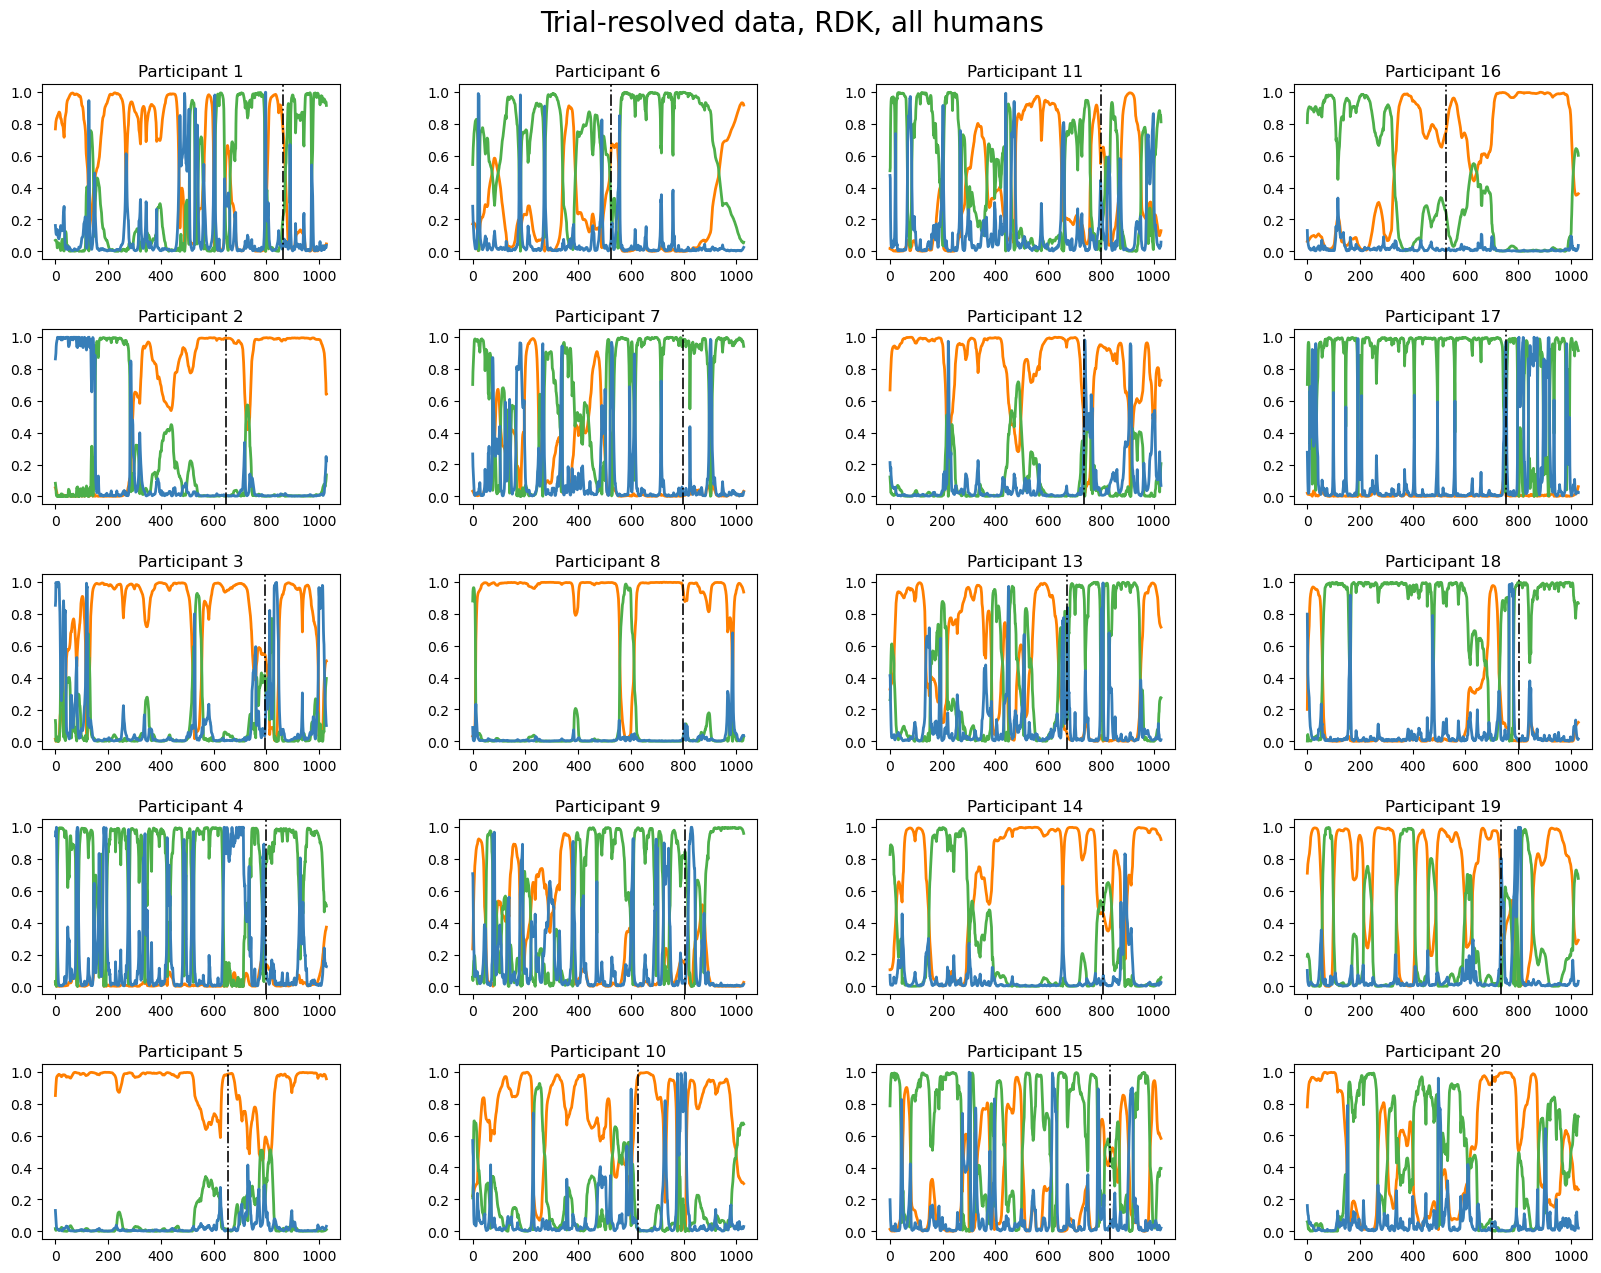

In [35]:
# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ijk = 0
klm = 0
part_id = 1

for participant in posterior_probs_RDK:
    for count, k in enumerate([0, 2, 1]):
        axes[ijk, klm].plot(participant[:, k], label="State " + str(k + 1), lw=2,
             color=cols[count])
    axes[ijk, klm].set_title(f"Participant {part_id}")
    axes[ijk, klm].axvline(x=list_trials_btts_D[part_id-1], color='black', linestyle='-.', alpha=0.9, linewidth=1.3)
    part_id += 1
    
    ijk += 1
    
    if ijk == 5:
        ijk = 0
        klm += 1
        
fig.suptitle('Trial-resolved data, RDK, all humans', fontsize=20, y=0.93)
fig.savefig("RDK_all_humans_GLM.svg")